In [15]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Variablen definieren:

In [25]:
path = '../data/raw/'
filenames = os.listdir(path)
filenames.remove('.gitkeep')
image_size = (150, 150)
val_split = 0.1
batch_size = 150

Funktionen:

In [3]:
def get_label(string):
    string  = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[0:-1])
    return string


In [26]:
def preprocessing(path, image_size, batch_size, val_split):
    """
    path:       to directory that contains the image files,
    val_split:  specified ratio of validation to training data (= percent of all images taken for validation)
    image_size: of the images (after resizing by the data generator, needs to be the same in the model)
    
    returns training and validation DataGenerator
    """
    filenames = os.listdir(path)
    filenames.remove('.gitkeep')
    df = pd.DataFrame(filenames, columns=['Filenames'])
    
    df['Label'] = df['Filenames'].apply(lambda x: get_label(x))
    
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = val_split,
                                                              rescale=1./255,
                                                              #rotation_range=40,
                                                              #width_shift_range=0.2,
                                                              #height_shift_range=0.2,
                                                              #shear_range=0.2,
                                                              #zoom_range=0.2,
                                                              #horizontal_flip=True,
                                                              #fill_mode='nearest')
                                                             )
    train_generator = datagen.flow_from_dataframe(df,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              subset='training')
    validation_generator = datagen.flow_from_dataframe(df,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              subset='validation')
    
    return train_generator, validation_generator

Preprocessing ausführen:

In [27]:
train_generator, validation_generator = preprocessing(path, image_size, batch_size, val_split)

Found 36000 validated image filenames belonging to 50 classes.
Found 4000 validated image filenames belonging to 50 classes.


### Defining the baseline model
Specify neccessary hyperparameters

In [60]:
loss = 'categorical_crossentropy' 
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam()#learning_rate=learning_rate)

kernels = 64
kernel_size = (3,3)
activation_conv = 'relu'
activation_dense = 'softmax'
neurons = 120

input_shape = (150,150)

#### Implement callback to stop when validation accuracy rises

In [55]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [56]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(kernels, kernel_size, activation=activation_conv, input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Second convolution
    tf.keras.layers.Conv2D(kernels, kernel_size, activation=activation_conv),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Third convolution
    tf.keras.layers.Conv2D(kernels, kernel_size, activation=activation_conv),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(neurons, activation=activation_conv),
    tf.keras.layers.Dense(50, activation=activation_dense)
])

# Print the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 64)      

In [57]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [58]:
history2 = model.fit(train_generator, epochs=40, steps_per_epoch=20, validation_data=validation_generator, verbose = 1, validation_steps=3, callbacks=[es_callback])

Epoch 1/40
20/20 [==============================] - 31s 2s/step - loss: 3.8678 - accuracy: 0.0310 - val_loss: 3.7837 - val_accuracy: 0.0533
Epoch 2/40
20/20 [==============================] - 32s 2s/step - loss: 3.6356 - accuracy: 0.0723 - val_loss: 3.4215 - val_accuracy: 0.1133
Epoch 3/40
20/20 [==============================] - 34s 2s/step - loss: 3.3290 - accuracy: 0.0983 - val_loss: 3.1331 - val_accuracy: 0.1133
Epoch 4/40
20/20 [==============================] - 34s 2s/step - loss: 3.0387 - accuracy: 0.1310 - val_loss: 2.8639 - val_accuracy: 0.1756
Epoch 5/40
20/20 [==============================] - 131s 7s/step - loss: 2.8639 - accuracy: 0.1677 - val_loss: 2.6782 - val_accuracy: 0.2356
Epoch 6/40
20/20 [==============================] - 33s 2s/step - loss: 2.7916 - accuracy: 0.1880 - val_loss: 2.7172 - val_accuracy: 0.2156
Epoch 7/40
20/20 [==============================] - 34s 2s/step - loss: 2.6618 - accuracy: 0.1957 - val_loss: 2.5724 - val_accuracy: 0.2289
Epoch 8/40
20/20 [=

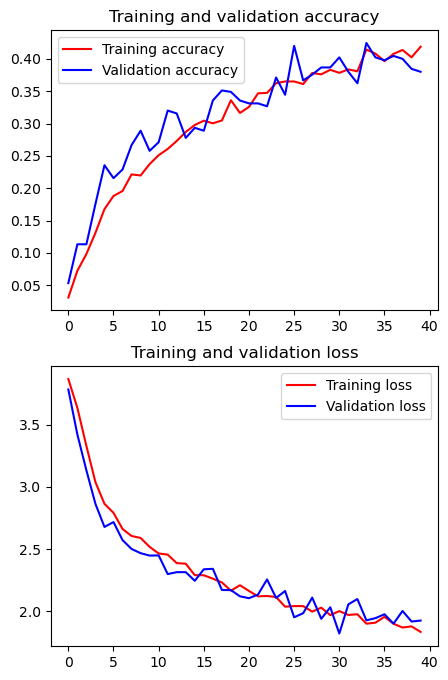

In [59]:
# Plot the results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(5,8))
fig.add_subplot(211)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

fig.add_subplot(212)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

#plt.savefig('/Users/tabea/Desktop/Accuracy_Loss_2Conv.png')
plt.show()

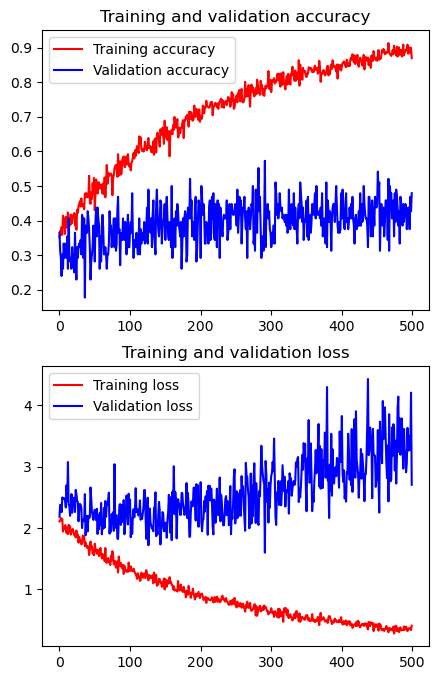

In [120]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(5,8))
fig.add_subplot(211)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
#plt.xlim(0,18)

fig.add_subplot(212)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
#plt.xlim(0,18)

plt.show()

In [139]:
pwd

'/Users/tabea/Desktop/tiny-bricks/src'